In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import ast
import re
import json
import pickle
from dotenv import load_dotenv

import pydot
from IPython.display import Image, display
from PIL import Image
import xml.etree.ElementTree as ET

from langchain_openai import AzureChatOpenAI
#from langchain_core.pydantic_v1 import BaseModel, Field
#from langchain_core.messages import HumanMessage
#from langchain_core.runnables import chain
#from langchain_core.output_parsers import JsonOutputParser
#from langchain_community.callbacks import get_openai_callback

#from langchain_experimental.open_clip import OpenCLIPEmbeddings

#from transformers import BertTokenizer, BertModel

import open_clip
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import shap

load_dotenv()

/opt/conda/envs/libsearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

- revoir les attributes values (il manque des espaces) VVV
- renommer les models : llm_model, clip_model, classification_model VVV
- ajouter au dataset de train une colonne avec le image_name (pour faire des vérifs derrière) VVV
- retirer les features les moins importantes (cross multiclass) VVV
- tester Modèle d'arbre et feature permutation pour mesurer la feature importance VVV

- tracer l'AUC et ROC curve VVV
- comparer avec un CNN les metrics

- classer les visual_clues (features) / visual_parts / attributes les plus déterminantes VVV
- focus sur une image mal prédite : pourquoi ? VVV

# Get visual clues for each class_label

In [2]:
def get_visual_parts(class_domain:str):
    visual_parts_prompt = """
    I would like to get a dictionary (json format) of the main visual parts of a given domain, themselves subdivided in visual parts, and so on.
    A visual part is something concrete, and must not be a characteristic or attribute (size, shape, lenght, colour, texture, luminosity).
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output
    As an exemple for the schema: {{'visual_part_1': {{'visual_part_1.1' :{{}}}}, {{'visual_part_1.2': {{}}}}, 'visual_part_2': {{'visual_part_2.1':{{}}, 'visual_part_2.2' : {{'visual_part_2.2.1':{{}}, 'visual_part_2.2.2':{{}}}}, 'visual_part_2.3':{{}}}}, 'visual_part_3': {{}}}}
    If there is no more subdivision, the value of a key-value pair should be an empty Python dictionary.
    One exemple : if the domain is "plane", the schema should be : {{'fuselage':{{'cockpit':{{}}, 'corgo_holds':{{}}, 'passenger_seats':{{}}}}, 'wings':{{'ailerons':{{}}, 'trailing_edge':{{}}, 'leading_edge':{{}}}}, 'landing_gear':{{'wheels':'tyres':{{}}, 'rims':{{}}}}, 'brakes':{{}}}}, 'engine':{{'turbines':{{}}, 'compressors':{{}}}}}}
    The visual parts (and the subdivisions) should be precise, but not too much. Some limitations :
    - there should be between 5 and 10 visual_parts at the first level of the tree
    - then between 0 and 5 at the second level
    - then between 0 and 5 at the third level
    - there should not be more than 3 levels
    Avoid spaces and '\n' in the output, pure JSON format.
    The domain for which I need the dictionary is : {}
    """
    return visual_parts_prompt.format(class_domain)

In [4]:
def get_visual_attributes(visual_parts_dict:dict):
    visual_attributes_prompt = """
    I would like to get the visual attributes of things.
    Visual attriutes could be : size, lenght, width, shape, color, texture, luminosity, opacity, material, thickness, level or moisture, level of flexibility. Do not limit to this list, there could be far more relevant visual attributes according to the visual parts.
    It is important to be precise and not to generic.
    Some examples : 
    - the visual attributes for a flower petals are : 'size', 'shape', 'color', 'peduncle size', 'incurvation'
    - the visual attributes for a motor engine : 'speed', 'number of turbines', 'position in the car'
    - the visual attributes for teeth : 'size', 'color', 'sharpness', 'alignment', 'healthy level'
    Fill in each empty dictionary of the input dictionary below by the corresponding visual attributes of the dictionary key, and add en empty dictionary as visual attribute value.
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output.
    Format example : 
    - if the input is : {{'visual_part_1': {{'visual_part_1.1' :{{}}}}, {{'visual_part_1.2': {{}}}}, 'visual_part_2': {{'visual_part_2.1':{{}}, 'visual_part_2.2' : {{'visual_part_2.2.1':{{}}, 'visual_part_2.2.2':{{}}}}, 'visual_part_2.3':{{}}}}}}
    - the output should be : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : {{}}, visual_attributes_1.1.2 : {{}}}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : {{}}, visual_attributes_1.2.2 : {{}}, , visual_attributes_1.2.3 : {{}}}}}}}}
    There should be between 3 and 7 visual attribute for each visual part.
    The input dictionary is : {}
    """
    return visual_attributes_prompt.format(visual_parts_dict)

In [5]:
def get_attribute_values(visual_attributes_dict:dict, class_label:str, class_domain: str):
    attribute_values_prompt = """
    For a given subclass (e.g. dog breed), I would like to get the attribute value of each visual attribute (e.g. the size, the shape, the color...) of each visual part (e.g. head, body, legs...), taking into account the global class (e.g. dog).
    Some exemples : 
    for the global class 'dog', the subclass 'rottweiler', the visual part 'head', the sub_visual_part 'teeth', the values are :
    - for the visual attribute 'size' : ' quite large'
    - for the visual attribute 'color' : 'white'
    - for the visual attribute 'sharpness' : 'very sharp'
    - for the visual attribute 'alignement' : 'scissor bite'
    The value should consider how the subclass is postionned in the whole global_class ('rottweiler' are, among the 'dogs', those who have 'very sharp' 'teeth')
    Sometimes, try to be more precise than the split "low" / "medium" / "high" if you can. For instance, you can specify measurement intervals : e.g. "less than 5 inches" / "5-10 inches" / "more than 10 inches" (of course it depends on the unit of measurement)
    Replace each empty dictionary of the input dictionary below by the corresponding attribute value of the dictionary key.
    The output should be a well-formatted JSON instance that conforms to the JSON schema below. Avoid spaces and '\n' in the output.
    Format example :
    - if the input is :{{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : {{}}, visual_attributes_1.1.2 : {{}}}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : {{}}, visual_attributes_1.2.2 : {{}}, , visual_attributes_1.2.3 : {{}}}}}}}}
    - the output should be : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : attribute_value_1.1.1, visual_attributes_1.1.2 : attribute_value_1.1.2}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : attribute_value_1.2.1, visual_attributes_1.2.2 : attribute_value_1.2.2, , visual_attributes_1.2.3 : attribute_value_1.2.3}}}}}}
    The global class is : {}
    The subclass is : {}
    The input dictionary is : {}
    """
    return attribute_values_prompt.format(class_domain, class_label, visual_attributes_dict)

In [7]:
def get_visual_clues_natural_language(visual_dict:dict):
    visual_clues_sentences_prompt = """
    The objective is to transform a nested Python dictionary values in natural language sentences by aggregatings all information of the nested brand in the sentence.
    The output should be a well-formatted JSON instance, the same as the input, but with the values replaced by string sentences. Avoid spaces and '\n' in the output.
    Format example :
    - if the input is : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : attribute_value_1.1.1, visual_attributes_1.1.2 : attribute_value_1.1.2}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : attribute_value_1.2.1, visual_attributes_1.2.2 : attribute_value_1.2.2, , visual_attributes_1.2.3 : attribute_value_1.2.3}}}}}}
    - the output should be like : {{'visual_part_1': {{'visual_part_1.1' :{{visual_attributes_1.1.1 : 'the visual_attributes_1.1.1 of the visual_part_1.1 is attribute_value_1.1.1', visual_attributes_1.1.2 : 'the visual_attributes_1.1.2 of the visual_part_1.1 is attribute_value_1.1.2'}}}}, {{'visual_part_1.2': {{visual_attributes_1.2.1 : 'the visual_attributes_1.2.1 of the visual_part_1.2 is attribute_value_1.2.1', visual_attributes_1.2.2 : 'the visual_attributes_1.2.2 of the visual_part_1.2 is attribute_value_1.2.2', , visual_attributes_1.2.3 : 'the visual_attributes_1.2.3 of the visual_part_1.2 is attribute_value_1.2.3'}}}}}}
    Make sure that sentences created are coherent.
    The input dictionary is : {}
    """
    return visual_clues_sentences_prompt.format(visual_dict)

In [8]:
def clean_visual_dict(visual_dict:dict):
    cleaning_dict_prompt = """
    could you remove spaces and '\n' in this text: {}
    """
    return cleaning_dict_prompt.format(visual_dict)

In [9]:
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [10]:
def get_visual_clues_class_domain_dict(class_domain:str, class_labels_list:list):
    
    llm_model = AzureChatOpenAI(
            temperature=0,
            deployment_name=os.getenv('CHAT_DEPLOYEMENT_NAME'),
            model_name=os.getenv('CHAT_MODEL_NAME'),
            openai_api_version=os.getenv('CHAT_OPENAI_API_VERSION'),
            openai_api_type=os.getenv('CHAT_OPEN_API_TYPE'),
            max_tokens=1024
        )
    
    # get visual parts dict of the class_domain
    visual_parts_dict = llm_model.predict(get_visual_parts(class_domain=class_domain))
    
    # enrich dict with all visual attributes for each visual part of the class_domain
    visual_parts_attributes_dict = llm_model.predict(get_visual_attributes(visual_parts_dict))
    clean_visual_parts_attributes_dict = re.sub(r' {2,}', '', visual_parts_attributes_dict).replace("\n", "")
    
    # now that we get the tree structure for the class_domain, let's have a dedicated dictionary for each class_label
    # we needed to ensure that visual_parts x visual_attributes are the same for all class_label
    class_domain_dict = {}
    
    for class_label in class_labels_list:
    
        # enrich dict with attribute values of the class_label for each visual attribute of the class_domain
        visual_parts_attributes_values_dict = llm_model.predict(get_attribute_values(visual_attributes_dict=clean_visual_parts_attributes_dict, class_label=class_label, class_domain=class_domain))
        clean_dict_str = re.sub(r' {2,}', '', visual_parts_attributes_values_dict).replace("\n", "")
        
        # transform attributes values by a natural language sentence that gathers all information of the visual clue (the tree branch)
        dict_with_sentences = llm_model.predict(get_visual_clues_natural_language(clean_dict_str))
        clean_dict_with_sentences = re.sub(r' {2,}', ' ', dict_with_sentences).replace("\n", "")
        clean_dict_with_sentences = ast.literal_eval(clean_dict_with_sentences)
        
        # flatten the dictionary by aggregating all branch information in one single key
        flatten_dict_class_label = flatten_dict(clean_dict_with_sentences)
        
        # add the class_label dict to the class_domain dict
        class_domain_dict[class_label] = flatten_dict_class_label
    
    return class_domain_dict

In [12]:
%%time
class_domain = 'dog'
class_labels_list = ['Bulldog', 'Scotch Terrier', 'Beagle', 'Chihuahua', 'Saluki', 'Lhasa', 'Clumber', 'Doberman', 'Chow', 'African Hunting Dog']

class_domain_dict = get_visual_clues_class_domain_dict(class_domain=class_domain, class_labels_list=class_labels_list)

/opt/conda/envs/libsearch/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


CPU times: user 431 ms, sys: 28 ms, total: 459 ms
Wall time: 8min 32s


In [13]:
class_domain_dict

{'Bulldog': {'head_eyes_size': 'the size of the eyes is medium',
  'head_eyes_color': 'the color of the eyes is brown',
  'head_eyes_shape': 'the shape of the eyes is round',
  'head_eyes_luminosity': 'the luminosity of the eyes is low',
  'head_eyes_alignment': 'the alignment of the eyes is wide-set',
  'head_ears_size': 'the size of the ears is small',
  'head_ears_shape': 'the shape of the ears is floppy',
  'head_ears_texture': 'the texture of the ears is smooth',
  'head_ears_flexibility': 'the flexibility of the ears is low',
  'head_ears_fur_length': 'the fur length of the ears is short',
  'head_nose_size': 'the size of the nose is medium',
  'head_nose_shape': 'the shape of the nose is rounded',
  'head_nose_color': 'the color of the nose is black',
  'head_nose_texture': 'the texture of the nose is smooth',
  'head_mouth_size': 'the size of the mouth is wide',
  'head_mouth_shape': 'the shape of the mouth is broad',
  'head_mouth_color': 'the color of the mouth is pink',
  'h

In [14]:
with open("dog_visual_clues_dict_10.json", "w") as f:
    json.dump(class_domain_dict, f)

In [20]:
with open("dog_visual_clues_dict_10.json", "r") as f:
    class_domain_dict = json.load(f)

In [21]:
# reaarange visual clues

collected_values = {}

for sub_dict in class_domain_dict.values():
    for sub_key, value in sub_dict.items():
        if sub_key not in collected_values:
            collected_values[sub_key] = []  # Initialize a list if sub-key is encountered first time
        collected_values[sub_key].append(value)
        
collected_values = {key:list(set(value)) for key,value in collected_values.items()}

aggregated_visual_clues = [value for values in collected_values.values() for value in values]
aggregated_visual_clues = list(set(aggregated_visual_clues))
aggregated_visual_clues

['the fur color of the back is varies',
 'the fur texture of the neck is silky',
 'the color of the fur is white with orange or lemon markings',
 'the color of the mouth is black',
 'the size of the paws is large',
 'the claw sharpness of the hind paws is moderately sharp',
 'the color of the fur is varies',
 'the flexibility of the tail is semi-flexible',
 'the fur length of the back is long',
 'the size of the ears is medium',
 'the size of the hind paws is small',
 'the fur length of the back is short to medium',
 'the color of the fur matches head fur color',
 'the size of the nose is medium',
 'the fur length of the back is medium',
 'the size of the hind legs paws is medium',
 'the claw sharpness of the hind_legs paws is moderate',
 'the fur texture of the neck is dense',
 'the fur color of the back matches body',
 'the flexibility of the ears is moderate',
 'the claw sharpness of the front legs paws is moderately sharp',
 'the size of the nose is large',
 'the thickness of the n

In [22]:
len(aggregated_visual_clues)

194

In [23]:
collected_values = {key:list(set(value)) for key,value in collected_values.items()}

In [24]:
sorted_dict = dict(sorted(collected_values.items(), key=lambda item: len(item[1]), reverse=True)[:10])
sorted_dict

{'head_fur_color': ['the color of the fur is mottled pattern of brown, black, and white',
  'the color of the fur is black and tan',
  'the color of the fur is red, black, blue, fawn, cream',
  'the color of the fur is cream, gold, red, grizzle and tan, tricolor, and black and tan',
  'the color of the fur is black',
  'the color of the fur is tricolor (black, white, and brown)',
  'the color of the fur is white with orange or lemon markings',
  'the color of the fur is fawn, white, or brindle',
  'the color of the fur is varies (black, white, grey, golden)',
  'the color of the fur is varies'],
 'body_fur_color': ['the color of the fur is mottled pattern of brown, black, and white',
  'the color of the fur is black and tan',
  'the color of the fur is red, black, blue, fawn, cream',
  'the color of the fur is black',
  'the color of the fur is tricolor',
  'the color of the fur matches head fur color',
  'the color of the fur is white with orange or lemon markings',
  'the color of th

In [25]:
# Load OpenCLIP model and preprocessing function
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")

In [26]:
def get_visual_clues_embeddings(visual_clues_list:list):

    visual_clues_embeddings = {}
    
    for visual_clue in visual_clues_list:
        tokens = open_clip.tokenize([visual_clue])
        with torch.no_grad():
            text_embedding = clip_model.encode_text(tokens)
        visual_clues_embeddings[visual_clue] = text_embedding
        
    return visual_clues_embeddings

In [27]:
%%time
visual_clues_embeddings = get_visual_clues_embeddings(aggregated_visual_clues)

CPU times: user 23.4 s, sys: 0 ns, total: 23.4 s
Wall time: 24.4 s


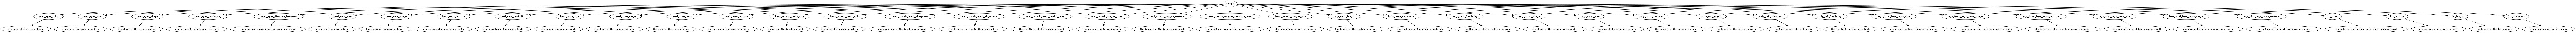

In [27]:
# display the tree of a given class_label

def dict_to_pydot(graph, class_domain_dict, class_label):
    """Recursively add nodes and edges from a nested dictionary to a pydot graph."""
    for key, value in class_domain_dict.items():
        node_name = f"{class_label}_{key}"
        graph.add_node(pydot.Node(node_name, label=key))
        graph.add_edge(pydot.Edge(class_label, node_name))
        
        # If the value is a dictionary, recursively add its children
        if isinstance(value, dict):
            dict_to_pydot(graph, value, node_name)
        else:
            # Create a leaf node for non-dict values
            leaf_name = f"{node_name}_{value}"
            graph.add_node(pydot.Node(leaf_name, label=str(value)))
            graph.add_edge(pydot.Edge(node_name, leaf_name))

# Create a new pydot graph
graph = pydot.Dot(graph_type='digraph')

# Add nodes and edges recursively from the nested dictionary
class_label = "beagle"
graph.add_node(pydot.Node(class_label))
dict_to_pydot(graph, class_domain_dict[class_label], class_label)

# Save the graph to a PNG file and display it
graph.write_png(f'{class_label}.png')
display(Image(filename=f'{class_label}.png'))

## test cells

In [3]:
llm_model = AzureChatOpenAI(
            temperature=0,
            deployment_name=os.getenv('CHAT_DEPLOYEMENT_NAME'),
            model_name=os.getenv('CHAT_MODEL_NAME'),
            openai_api_version=os.getenv('CHAT_OPENAI_API_VERSION'),
            openai_api_type=os.getenv('CHAT_OPEN_API_TYPE'),
            max_tokens=1024
        )

In [4]:
visual_parts_dict = llm_model.predict(get_visual_parts(class_domain='dog'))
visual_parts_dict

/opt/conda/envs/libsearch/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'{"head":{"eyes":{},"ears":{},"nose":{},"mouth":{},"fur":{}},"body":{"neck":{},"back":{},"belly":{},"fur":{}},"legs":{"front_legs":{"paws":{}},"hind_legs":{"paws":{}}},"tail":{},"paws":{"claws":{}}}'

In [101]:
visual_parts_attributes_dict = llm_model.predict(get_visual_attributes(visual_parts_dict))
visual_parts_attributes_dict

'{\n    "head": {\n        "eyes": {\n            "size": {},\n            "color": {},\n            "shape": {},\n            "luminosity": {},\n            "alignment": {}\n        },\n        "ears": {\n            "size": {},\n            "shape": {},\n            "texture": {},\n            "flexibility": {},\n            "fur_length": {}\n        },\n        "nose": {\n            "size": {},\n            "shape": {},\n            "color": {},\n            "texture": {}\n        },\n        "mouth": {\n            "size": {},\n            "shape": {},\n            "color": {},\n            "teeth_alignment": {},\n            "lip_thickness": {}\n        },\n        "fur": {\n            "color": {},\n            "texture": {},\n            "length": {},\n            "density": {}\n        }\n    },\n    "body": {\n        "neck": {\n            "length": {},\n            "thickness": {},\n            "fur_texture": {}\n        },\n        "back": {\n            "width": {},\n    

In [ ]:
updated_text = re.sub(r' {2,}', '', text)

In [102]:
clean_visual_parts_attributes_dict = visual_parts_attributes_dict.replace("\n", "")#.replace(" ", "")
clean_visual_parts_attributes_dict = re.sub(r' {2,}', '', clean_visual_parts_attributes_dict)
clean_visual_parts_attributes_dict

'{"head": {"eyes": {"size": {},"color": {},"shape": {},"luminosity": {},"alignment": {}},"ears": {"size": {},"shape": {},"texture": {},"flexibility": {},"fur_length": {}},"nose": {"size": {},"shape": {},"color": {},"texture": {}},"mouth": {"size": {},"shape": {},"color": {},"teeth_alignment": {},"lip_thickness": {}},"fur": {"color": {},"texture": {},"length": {},"density": {}}},"body": {"neck": {"length": {},"thickness": {},"fur_texture": {}},"back": {"width": {},"fur_length": {},"fur_color": {}},"belly": {"softness": {},"fur_density": {},"fur_color": {}},"fur": {"color": {},"texture": {},"length": {},"density": {}}},"legs": {"front_legs": {"paws": {"size": {},"fur_length": {},"claw_sharpness": {}}},"hind_legs": {"paws": {"size": {},"fur_length": {},"claw_sharpness": {}}}},"tail": {"length": {},"fur_density": {},"fur_color": {},"flexibility": {}},"paws": {"claws": {"sharpness": {},"length": {},"curvature": {}}}}'

In [103]:
visual_parts_attributes_values_dict = llm_model.predict(get_attribute_values(visual_attributes_dict=clean_visual_parts_attributes_dict, class_label='bulldog', class_domain='dog'))
visual_parts_attributes_values_dict

'{\n  "head": {\n    "eyes": {\n      "size": "small",\n      "color": "dark brown",\n      "shape": "round",\n      "luminosity": "low",\n      "alignment": "wide set"\n    },\n    "ears": {\n      "size": "medium",\n      "shape": "floppy",\n      "texture": "smooth",\n      "flexibility": "low",\n      "fur_length": "short"\n    },\n    "nose": {\n      "size": "small",\n      "shape": "rounded",\n      "color": "black",\n      "texture": "smooth"\n    },\n    "mouth": {\n      "size": "medium",\n      "shape": "wide",\n      "color": "pink",\n      "teeth_alignment": "scissor bite",\n      "lip_thickness": "thick"\n    },\n    "fur": {\n      "color": "fawn, white, or brindle",\n      "texture": "smooth",\n      "length": "short",\n      "density": "dense"\n    }\n  },\n  "body": {\n    "neck": {\n      "length": "short",\n      "thickness": "thick",\n      "fur_texture": "smooth"\n    },\n    "back": {\n      "width": "broad",\n      "fur_length": "short",\n      "fur_color": "mat

In [104]:
clean_dict_str = visual_parts_attributes_values_dict.replace("\n", "")
clean_dict_str = re.sub(r' {2,}', '', clean_dict_str)
clean_dict_str

'{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},"hind_legs":

In [105]:
dict_with_sentences = llm_model.predict(get_visual_clues_natural_language(clean_dict_str))#.replace("\n", "").replace(" ", "")
dict_with_sentences

'{\n  "head": {\n    "eyes": {\n      "size": "the size of the eyes is small",\n      "color": "the color of the eyes is dark brown",\n      "shape": "the shape of the eyes is round",\n      "luminosity": "the luminosity of the eyes is low",\n      "alignment": "the alignment of the eyes is wide set"\n    },\n    "ears": {\n      "size": "the size of the ears is medium",\n      "shape": "the shape of the ears is floppy",\n      "texture": "the texture of the ears is smooth",\n      "flexibility": "the flexibility of the ears is low",\n      "fur_length": "the fur length of the ears is short"\n    },\n    "nose": {\n      "size": "the size of the nose is small",\n      "shape": "the shape of the nose is rounded",\n      "color": "the color of the nose is black",\n      "texture": "the texture of the nose is smooth"\n    },\n    "mouth": {\n      "size": "the size of the mouth is medium",\n      "shape": "the shape of the mouth is wide",\n      "color": "the color of the mouth is pink",\

In [106]:
result = re.sub(r' {2,}', ' ', dict_with_sentences)
result = result.replace("\n", "")
result = ast.literal_eval(result)
result

{'head': {'eyes': {'size': 'the size of the eyes is small',
   'color': 'the color of the eyes is dark brown',
   'shape': 'the shape of the eyes is round',
   'luminosity': 'the luminosity of the eyes is low',
   'alignment': 'the alignment of the eyes is wide set'},
  'ears': {'size': 'the size of the ears is medium',
   'shape': 'the shape of the ears is floppy',
   'texture': 'the texture of the ears is smooth',
   'flexibility': 'the flexibility of the ears is low',
   'fur_length': 'the fur length of the ears is short'},
  'nose': {'size': 'the size of the nose is small',
   'shape': 'the shape of the nose is rounded',
   'color': 'the color of the nose is black',
   'texture': 'the texture of the nose is smooth'},
  'mouth': {'size': 'the size of the mouth is medium',
   'shape': 'the shape of the mouth is wide',
   'color': 'the color of the mouth is pink',
   'teeth_alignment': 'the teeth alignment of the mouth is scissor bite',
   'lip_thickness': 'the lip thickness of the mo

In [107]:
flatten_dict_class_label = flatten_dict(result)
flatten_dict_class_label

{'head_eyes_size': 'the size of the eyes is small',
 'head_eyes_color': 'the color of the eyes is dark brown',
 'head_eyes_shape': 'the shape of the eyes is round',
 'head_eyes_luminosity': 'the luminosity of the eyes is low',
 'head_eyes_alignment': 'the alignment of the eyes is wide set',
 'head_ears_size': 'the size of the ears is medium',
 'head_ears_shape': 'the shape of the ears is floppy',
 'head_ears_texture': 'the texture of the ears is smooth',
 'head_ears_flexibility': 'the flexibility of the ears is low',
 'head_ears_fur_length': 'the fur length of the ears is short',
 'head_nose_size': 'the size of the nose is small',
 'head_nose_shape': 'the shape of the nose is rounded',
 'head_nose_color': 'the color of the nose is black',
 'head_nose_texture': 'the texture of the nose is smooth',
 'head_mouth_size': 'the size of the mouth is medium',
 'head_mouth_shape': 'the shape of the mouth is wide',
 'head_mouth_color': 'the color of the mouth is pink',
 'head_mouth_teeth_alignmen

In [108]:
clean_dict_str

'{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},"hind_legs":

In [111]:
visual_dict

{'bulldog': '{"head": {"eyes": {"size": "small","color": "dark brown","shape": "round","luminosity": "low","alignment": "wide set"},"ears": {"size": "medium","shape": "floppy","texture": "smooth","flexibility": "low","fur_length": "short"},"nose": {"size": "small","shape": "rounded","color": "black","texture": "smooth"},"mouth": {"size": "medium","shape": "wide","color": "pink","teeth_alignment": "scissor bite","lip_thickness": "thick"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"body": {"neck": {"length": "short","thickness": "thick","fur_texture": "smooth"},"back": {"width": "broad","fur_length": "short","fur_color": "matches body"},"belly": {"softness": "moderate","fur_density": "dense","fur_color": "matches body"},"fur": {"color": "fawn, white, or brindle","texture": "smooth","length": "short","density": "dense"}},"legs": {"front_legs": {"paws": {"size": "medium","fur_length": "short","claw_sharpness": "moderately sharp"}},

In [114]:
def dict_to_pydot(graph, data, parent_name):
    """Recursively add nodes and edges from a nested dictionary to a pydot graph."""
    for key, value in data.items():
        node_name = f"{parent_name}_{key}"
        graph.add_node(pydot.Node(node_name, label=key))
        graph.add_edge(pydot.Edge(parent_name, node_name))
        
        # If the value is a dictionary, recursively add its children
        if isinstance(value, dict):
            dict_to_pydot(graph, value, node_name)
        else:
            # Create a leaf node for non-dict values
            leaf_name = f"{node_name}_{value}"
            graph.add_node(pydot.Node(leaf_name, label=str(value)))
            graph.add_edge(pydot.Edge(node_name, leaf_name))

# Create a new pydot graph
graph = pydot.Dot(graph_type='digraph')

# Add nodes and edges recursively from the nested dictionary
root_name = "bulldog"
visual_dict = {}
visual_dict[root_name] = ast.literal_eval(clean_dict_str)
graph.add_node(pydot.Node(root_name))
dict_to_pydot(graph, visual_dict[root_name], root_name)

# Save the graph to a PNG file and display it
graph.write_png('bulldog.png')
display(Image(filename='bulldog.png'))

TypeError: 'module' object is not callable

# Train classification model

In [39]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bboxes = []
    
    # Extract bounding box coordinates
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax, ymax))
    
    return bboxes

In [40]:
def get_image_cosine_similarities(image_name, image_dir, label_dir, annotation_dir, text_embeddings):
    
    image_path = os.path.join(image_dir, label_dir, image_name+'.jpg')
    annotation_path = os.path.join(annotation_dir, label_dir, image_name)
    
    # get the bounding boxes of the image to know where the important part is located on the image
    # and cropp the image
    bounding_boxes = parse_annotation(annotation_path)
    image = Image.open(image_path)
    cropped_image = image.crop(bounding_boxes[0])
    inputs = preprocess(cropped_image).unsqueeze(0)

    # get image embedding from CLIP
    with torch.no_grad():
        img_embedding = clip_model.encode_image(inputs)
    
    # calculate cosine similarity between the image and each visual clue sentence
    image_texts_similarities = {text: F.cosine_similarity(img_embedding, text_embedding, dim=-1).item() for text, text_embedding in text_embeddings.items()}
    
    return image_texts_similarities

In [31]:
%%time
# create classification dataframe

image_dir='../stanford-dogs/images/Images'
annotation_dir = '../stanford-dogs/annotations/Annotation'

selected_class_labels = ['French_bulldog', 'Scotch_terrier', 'beagle', 'Chihuahua', 'Saluki', 'Lhasa', 'clumber', 'Doberman', 'chow', 'African_hunting_dog']
class_label_folder = [folder for folder in os.listdir(image_dir) if any(class_label in folder for class_label in selected_class_labels)]

df_classification = pd.DataFrame(columns=['class_label', 'image_name']+aggregated_visual_clues)

for folder in class_label_folder:
    
    folder_path = os.path.join(annotation_dir, folder)
    class_label = folder.split('-')[1]
    image_names = [img for img in os.listdir(folder_path) if '.ipynb_checkpoints' not in img]
    
    for image_name in image_names:
        image_text_similarities = get_image_cosine_similarities(image_name=image_name,
                                                                image_dir=image_dir,
                                                                label_dir=folder,
                                                                annotation_dir=annotation_dir,
                                                                text_embeddings=visual_clues_embeddings)
        image_text_similarities['class_label'] = class_label
        image_text_similarities['image_name'] = image_name
        df_classification = pd.concat([df_classification, pd.DataFrame.from_dict(image_text_similarities, orient='index').T])

CPU times: user 6min 48s, sys: 923 ms, total: 6min 49s
Wall time: 7min 26s


In [32]:
df_classification

,class_label,image_name,the fur texture of the neck is smooth,the flexibility of the ears is stiff,the fur length of the hind_legs paws is short,the claw sharpness of the hind paws is very sharp,"the color of the fur is red, black, blue, fawn, cream",the claw sharpness of the front paws is very sharp,the luminosity of the eyes is moderate,the texture of the fur is silky,...,the flexibility of the ears is high,the color of the belly matches body color,the fur length of the front legs paws is short,the fur length of the hind paws is short,the sharpness of the claws is moderately sharp,the fur color of the back is black and tan,the thickness of the neck is slender,the fur texture of the neck is dense,the size of the nose is small,the width of the back is moderate
0,Chihuahua,n02085620_3045,0.161216,0.182279,0.167816,0.156847,0.210202,0.17869,0.130356,0.16429,...,0.188311,0.178257,0.185115,0.166756,0.154443,0.155602,0.149541,0.159864,0.168969,0.129423
0,Chihuahua,n02085620_3942,0.203049,0.277777,0.206465,0.205923,0.247919,0.231452,0.178718,0.18402,...,0.271274,0.193573,0.21293,0.212879,0.172582,0.22188,0.198004,0.196799,0.236632,0.151845
0,Chihuahua,n02085620_3402,0.204543,0.255857,0.202277,0.210075,0.211503,0.226324,0.172146,0.200675,...,0.247774,0.195563,0.211799,0.211067,0.189406,0.193076,0.196834,0.199956,0.210314,0.166363
0,Chihuahua,n02085620_4673,0.186748,0.237095,0.16615,0.174659,0.203893,0.209217,0.156406,0.17749,...,0.234361,0.153233,0.192861,0.179573,0.147489,0.196798,0.174412,0.176556,0.219138,0.141336
0,Chihuahua,n02085620_1569,0.207945,0.21764,0.225167,0.163324,0.255428,0.198794,0.156906,0.219534,...,0.217498,0.189914,0.242109,0.220316,0.141943,0.258494,0.182587,0.194198,0.201745,0.161852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Doberman,n02107142_4632,0.183794,0.263383,0.227447,0.22897,0.22819,0.239728,0.154021,0.166431,...,0.260163,0.179351,0.230375,0.226558,0.212879,0.240472,0.212953,0.175122,0.197908,0.181743
0,Doberman,n02107142_21,0.198733,0.229712,0.171864,0.166934,0.199631,0.207249,0.168918,0.162366,...,0.232451,0.156867,0.201311,0.176537,0.182993,0.233793,0.208592,0.18512,0.231913,0.162327
0,Doberman,n02107142_17564,0.185798,0.238111,0.184428,0.184391,0.171251,0.195019,0.137787,0.144199,...,0.245588,0.167113,0.193566,0.173437,0.163351,0.169895,0.247419,0.171782,0.1839,0.154471
0,Doberman,n02107142_13677,0.179991,0.233249,0.184951,0.205507,0.212963,0.237949,0.122473,0.149957,...,0.233101,0.142607,0.206417,0.19068,0.223564,0.205099,0.208297,0.17732,0.198014,0.155788


In [33]:
df_classification.to_csv('dog_visual_clues_similarities_10.csv', index=False)

In [3]:
df_classification = pd.read_csv('dog_visual_clues_similarities_10.csv')

In [4]:
df_classification = df_classification.reset_index(drop=True)
df_classification

,class_label,image_name,the fur texture of the neck is smooth,the flexibility of the ears is stiff,the fur length of the hind_legs paws is short,the claw sharpness of the hind paws is very sharp,"the color of the fur is red, black, blue, fawn, cream",the claw sharpness of the front paws is very sharp,the luminosity of the eyes is moderate,the texture of the fur is silky,...,the flexibility of the ears is high,the color of the belly matches body color,the fur length of the front legs paws is short,the fur length of the hind paws is short,the sharpness of the claws is moderately sharp,the fur color of the back is black and tan,the thickness of the neck is slender,the fur texture of the neck is dense,the size of the nose is small,the width of the back is moderate
0,Chihuahua,n02085620_3045,0.161216,0.182279,0.167816,0.156847,0.210202,0.178690,0.130356,0.164290,...,0.188311,0.178257,0.185115,0.166756,0.154443,0.155602,0.149541,0.159864,0.168969,0.129423
1,Chihuahua,n02085620_3942,0.203049,0.277777,0.206465,0.205923,0.247919,0.231452,0.178718,0.184020,...,0.271274,0.193573,0.212930,0.212879,0.172582,0.221880,0.198004,0.196799,0.236632,0.151845
2,Chihuahua,n02085620_3402,0.204543,0.255857,0.202277,0.210075,0.211503,0.226324,0.172146,0.200675,...,0.247774,0.195563,0.211799,0.211067,0.189406,0.193076,0.196834,0.199956,0.210314,0.166363
3,Chihuahua,n02085620_4673,0.186748,0.237095,0.166150,0.174659,0.203893,0.209217,0.156406,0.177490,...,0.234361,0.153233,0.192861,0.179573,0.147489,0.196798,0.174412,0.176556,0.219138,0.141336
4,Chihuahua,n02085620_1569,0.207945,0.217640,0.225167,0.163324,0.255428,0.198794,0.156906,0.219534,...,0.217498,0.189914,0.242109,0.220316,0.141943,0.258494,0.182587,0.194198,0.201745,0.161852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,Doberman,n02107142_4632,0.183794,0.263383,0.227447,0.228970,0.228190,0.239728,0.154021,0.166431,...,0.260163,0.179351,0.230375,0.226558,0.212879,0.240472,0.212953,0.175122,0.197908,0.181743
1711,Doberman,n02107142_21,0.198733,0.229712,0.171864,0.166934,0.199631,0.207249,0.168918,0.162366,...,0.232451,0.156867,0.201311,0.176537,0.182993,0.233793,0.208592,0.185120,0.231913,0.162327
1712,Doberman,n02107142_17564,0.185798,0.238111,0.184428,0.184391,0.171251,0.195019,0.137787,0.144199,...,0.245588,0.167113,0.193566,0.173437,0.163351,0.169895,0.247419,0.171782,0.183900,0.154471
1713,Doberman,n02107142_13677,0.179991,0.233249,0.184951,0.205507,0.212963,0.237949,0.122473,0.149957,...,0.233101,0.142607,0.206417,0.190680,0.223564,0.205099,0.208297,0.177320,0.198014,0.155788


In [5]:
df_classification = df_classification.reset_index(drop=True)
X = df_classification#.drop(columns=['class_label', 'image_name'])
y = df_classification['class_label']

# we train the model with most important features
with open('most_important_features.pkl', 'rb') as f:
    most_important_features_list = pickle.load(f)
#X = X[most_important_features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# we keep a X_test_label dataframe to make some further analysis on bad predictions
X_train = X_train.drop(columns=['class_label', 'image_name'])
X_train = X_train[most_important_features_list]
X_test_label = X_test.copy()
X_test = X_test.drop(columns=['class_label', 'image_name'])
X_test = X_test[most_important_features_list]

#param_grid = {
#    "n_estimators": [100, 200],
#    "max_depth": [None, 10, 20],
#    "min_samples_split": [2, 5, 10],
#    "min_samples_leaf": [1, 2, 4],
#    "max_features": ["sqrt", "log2"],
#}
#
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
#grid_search.fit(X_train, y_train)
#model = grid_search.best_estimator_

#model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#model = RandomForestClassifier(n_estimators=200,
#                               max_depth=None,
#                               max_features='log2',
#                               min_samples_leaf=1,
#                               min_samples_split=2,
#                               random_state=42)

model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9128
Precision: 0.9178
Recall: 0.9128
F1 Score: 0.9130


In [6]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

African_hunting_dog       0.89      0.94      0.92        18
          Chihuahua       1.00      0.79      0.88        14
           Doberman       0.89      1.00      0.94         8
     French_bulldog       1.00      1.00      1.00        18
              Lhasa       0.95      0.86      0.90        22
             Saluki       0.86      0.90      0.88        20
     Scotch_terrier       0.83      0.94      0.88        16
             beagle       0.93      0.88      0.90        16
               chow       0.96      0.92      0.94        26
            clumber       0.81      0.93      0.87        14

           accuracy                           0.91       172
          macro avg       0.91      0.92      0.91       172
       weighted avg       0.92      0.91      0.91       172



In [17]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [7]:
X_test_label['pred'] = y_pred
X_test_label = X_test_label[['class_label', 'image_name', 'pred']]

In [39]:
X_test_label.sample(5)

,class_label,image_name,pred
530,French_bulldog,n02108915_5306,French_bulldog
1330,Scotch_terrier,n02097298_8552,Scotch_terrier
610,French_bulldog,n02108915_8923,French_bulldog
324,chow,n02112137_6334,chow
1161,Lhasa,n02098413_6113,Lhasa


# Plot outputs

In [7]:
# Get feature importances from the model
importances = model.feature_importances_
feature_names = list(X_train.columns)
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

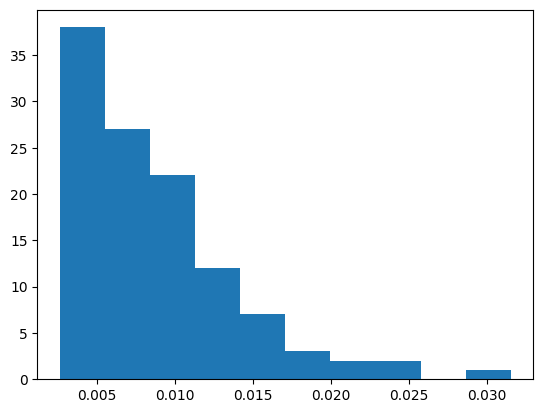

In [8]:
plt.hist(importance_df.Importance);

In [9]:
# Permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean,
    "Importance Std": perm_importance.importances_std
}).sort_values(by="Importance", ascending=False)

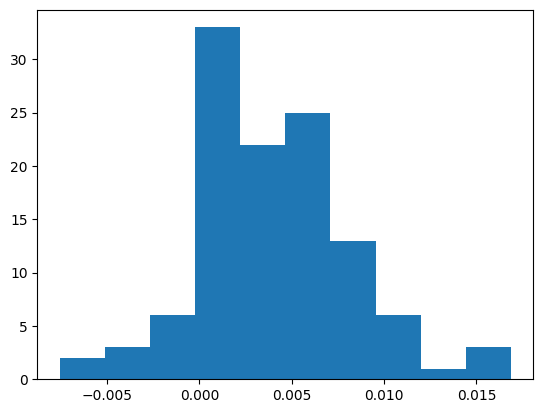

In [10]:
plt.hist(perm_importance_df.Importance);

## top class features

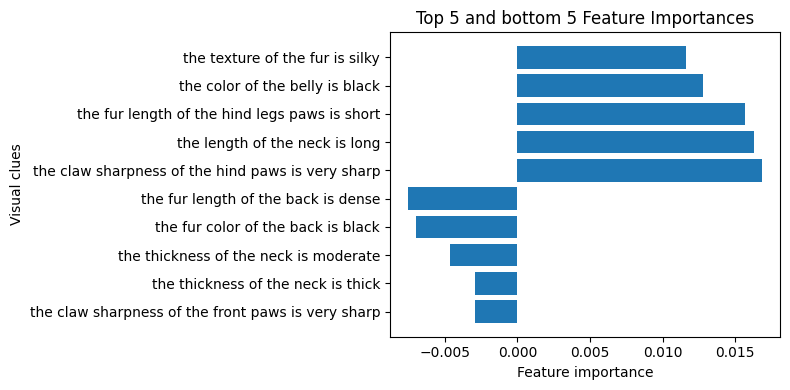

In [18]:
top_10 = perm_importance_df.tail(5)
bottom_10 = perm_importance_df.head(5)

# Combine the two
top_and_bottom = pd.concat([top_10, bottom_10])

plt.figure(figsize=(8, 4))
plt.barh(top_and_bottom["Feature"], top_and_bottom["Importance"])
plt.title("Top 5 and bottom 5 Feature Importances")
plt.xlabel("Feature importance")
plt.ylabel("Visual clues")
plt.tight_layout()
plt.show()

## top visual parts/attributes/clues

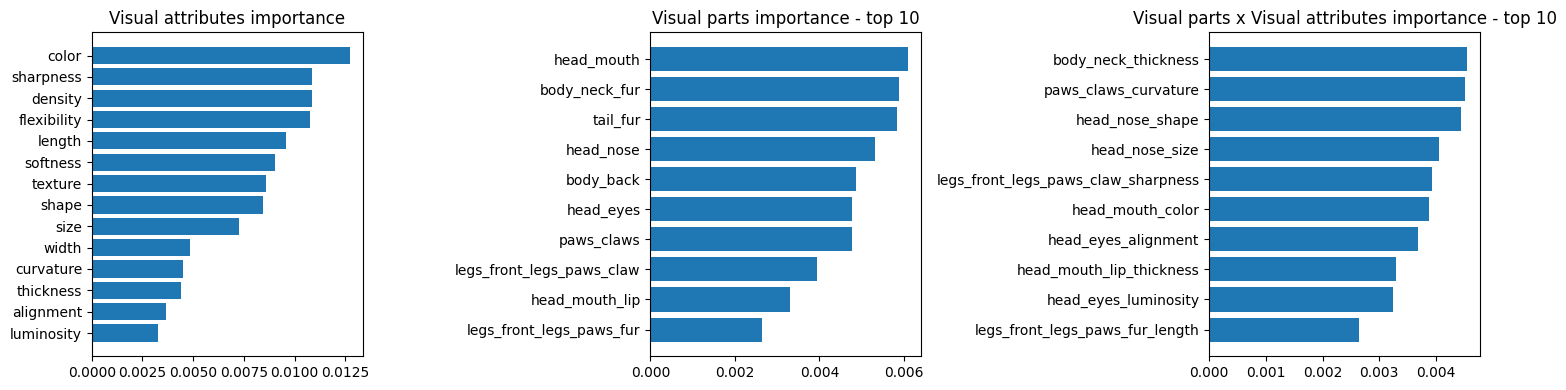

In [38]:
# we rank best visual parts / attributes to classify dogs

def map_to_visual_clue(value):
    for key, values in collected_values.items():
        if value in values:
            return key
    return None

importance_df['visual_clue'] = importance_df['Feature'].apply(map_to_visual_clue)
importance_df['attribute'] = importance_df['visual_clue'].apply(lambda x: x.split('_')[-1])
importance_df['visual_part'] = importance_df['visual_clue'].apply(lambda x: "_".join(x.split('_')[:-1]))

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4))

attributes_importance = importance_df.groupby('attribute')['Importance'].mean().sort_values(ascending=True)
axes[0].barh(attributes_importance.index, attributes_importance);
axes[0].set_title('Visual attributes importance');

visual_part_importance = importance_df.groupby('visual_part')['Importance'].mean().sort_values(ascending=True)[:-12]
axes[1].barh(visual_part_importance.index, visual_part_importance);
axes[1].set_title('Visual parts importance - top 10');

visual_clue_importance = importance_df.groupby('visual_clue')['Importance'].mean().sort_values(ascending=True)[:-29]
axes[2].barh(visual_clue_importance.index, visual_clue_importance);
axes[2].set_title('Visual parts x Visual attributes importance - top 10');

plt.tight_layout()

## grid search feature importance threshold

Best Threshold: -0.003
Best Cross-Validation Accuracy: 0.8950437317784257
Number of Features Selected: 175


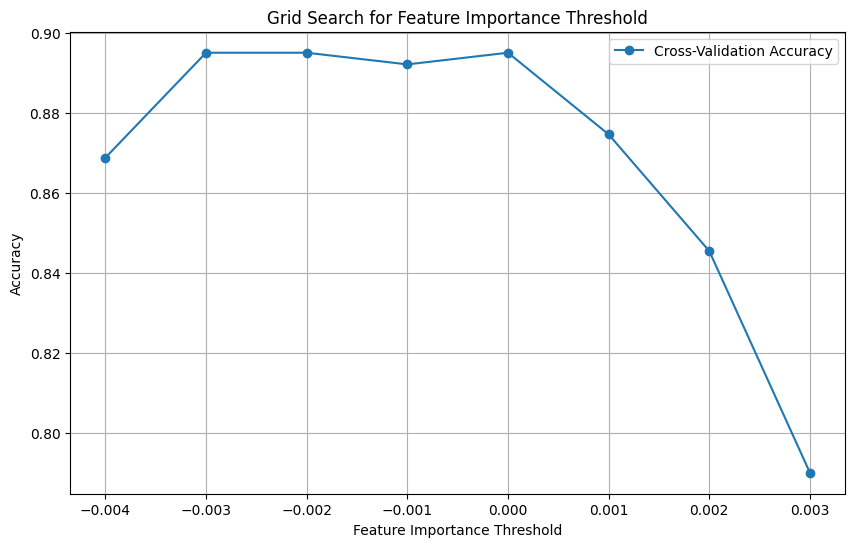

In [73]:
# we do a grid search to find the most optimal number of features to use 

def evaluate_with_threshold(threshold):
    #selected_features = list(importance_df[importance_df.Importance > threshold].Feature)
    selected_features = list(perm_importance_df[perm_importance_df.Importance > threshold].Feature)
    X_selected = X[selected_features]
    
    X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model_subset = RandomForestClassifier(random_state=42, n_jobs=-1)
    model_subset.fit(X_train_selected, y_train)
    
    y_pred_selected = model_subset.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred_selected)
    
    return accuracy, len(selected_features)  # Return mean score and number of features

#thresholds_importance = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
thresholds_perm_importance = [-0.004, -0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003]

results = []
for threshold in thresholds_perm_importance:
    accuracy, n_features = evaluate_with_threshold(threshold)
    results.append((threshold, accuracy, n_features))

best_threshold, best_score, best_n_features = max(results, key=lambda x: x[1])

print(f"Best Threshold: {best_threshold}")
print(f"Best Cross-Validation Accuracy: {best_score}")
print(f"Number of Features Selected: {best_n_features}")

thresholds, scores, n_features = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores, label='Cross-Validation Accuracy', marker='o')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Accuracy')
plt.title('Grid Search for Feature Importance Threshold')
plt.legend()
plt.grid(True)
plt.show()

## ROC curve

In [161]:
y_binarized = label_binarize(y, classes=list(y.unique()))
y_test_binarized = label_binarize(y_test, classes=list(y.unique()))

n_classes = y_binarized.shape[1]

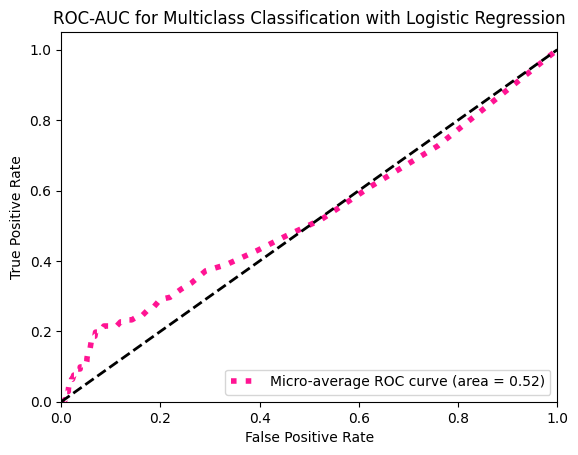

In [163]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## Plot the ROC curves
#plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green']
#for i in range(n_classes):
#    plt.plot(fpr[i], tpr[i], lw=2,
#             label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Multiclass Classification with Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Confusion matrix

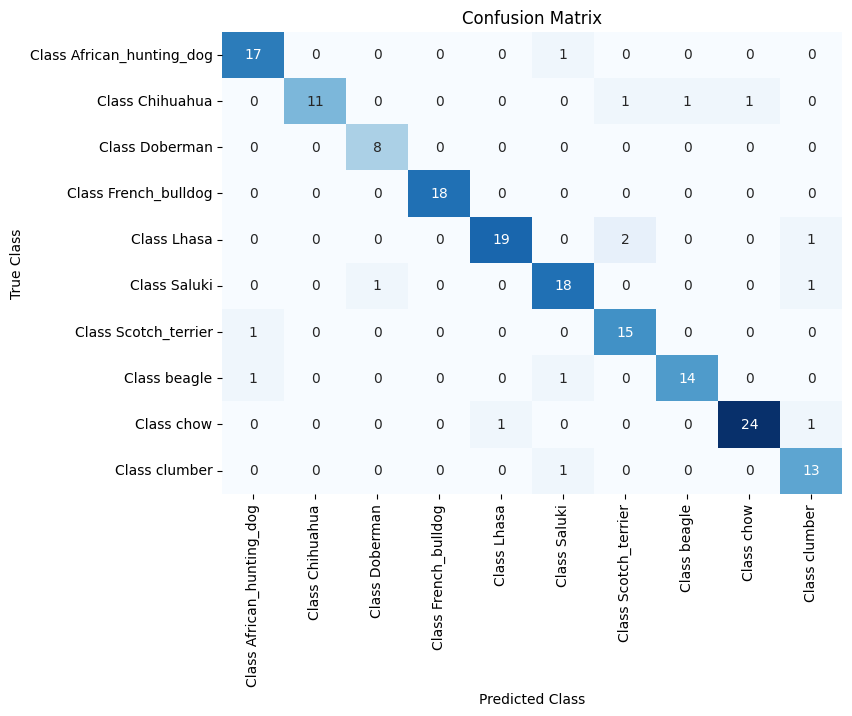

In [160]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=[f'Class {i}' for i in np.unique(y)],
            yticklabels=[f'Class {i}' for i in np.unique(y)])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

## top class_label features

In [166]:
# Focus on feature importance for each class_label
# For that, we need train one vs all logistic regression

ova_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
ova_model.fit(X_train, y_train)

feature_names = X_train.columns
coefficients = ova_model.coef_  # Shape: (n_classes, n_features)

# Convert to DataFrame for easier manipulation
feature_importances = pd.DataFrame(np.abs(coefficients).T,  # Use np.abs() to get absolute values
                                   index=feature_names,
                                   columns=y.unique())

feature_importances

/opt/conda/envs/libsearch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Chihuahua,clumber,chow,French_bulldog,beagle,Saluki,Lhasa,Scotch_terrier,African_hunting_dog,Doberman
the color of the fur is black and tan,2.253244,1.020181,2.257660,1.195356,0.943654,1.630686,0.771167,0.255507,2.602249,2.838935
the length of the neck is long,1.015433,0.706138,1.702619,0.250729,1.304802,2.402135,0.549561,0.248312,0.591814,0.562034
the fur color of the back is black,1.171199,1.141818,0.663309,0.023236,0.151613,0.702400,3.367112,2.656080,1.328465,1.901411
the size of the ears is small,0.158456,1.888535,0.335404,2.005488,0.571109,1.334842,0.943031,0.417053,1.946500,1.895514
the claw sharpness of the hind paws is moderately sharp,3.128529,0.600337,0.294038,0.922455,1.531619,1.334858,0.831442,0.392926,1.194662,0.069837
...,...,...,...,...,...,...,...,...,...,...
the fur color of the back is white with orange or lemon markings,0.031763,0.379293,0.836071,1.406615,0.149149,0.725245,1.602160,0.235565,0.870900,2.275043
the shape of the nose is broad,0.848541,0.919189,0.085523,0.538338,0.216555,0.403682,1.036682,1.041815,0.473098,0.649557
the thickness of the tail is thin,0.346744,0.322655,0.361696,0.563134,0.727969,1.802823,1.471429,0.329570,0.535247,0.628159
the size of the hind legs paws is small,0.963415,1.104280,1.049233,0.404366,1.527667,0.467566,0.935865,1.429095,0.876114,1.269576


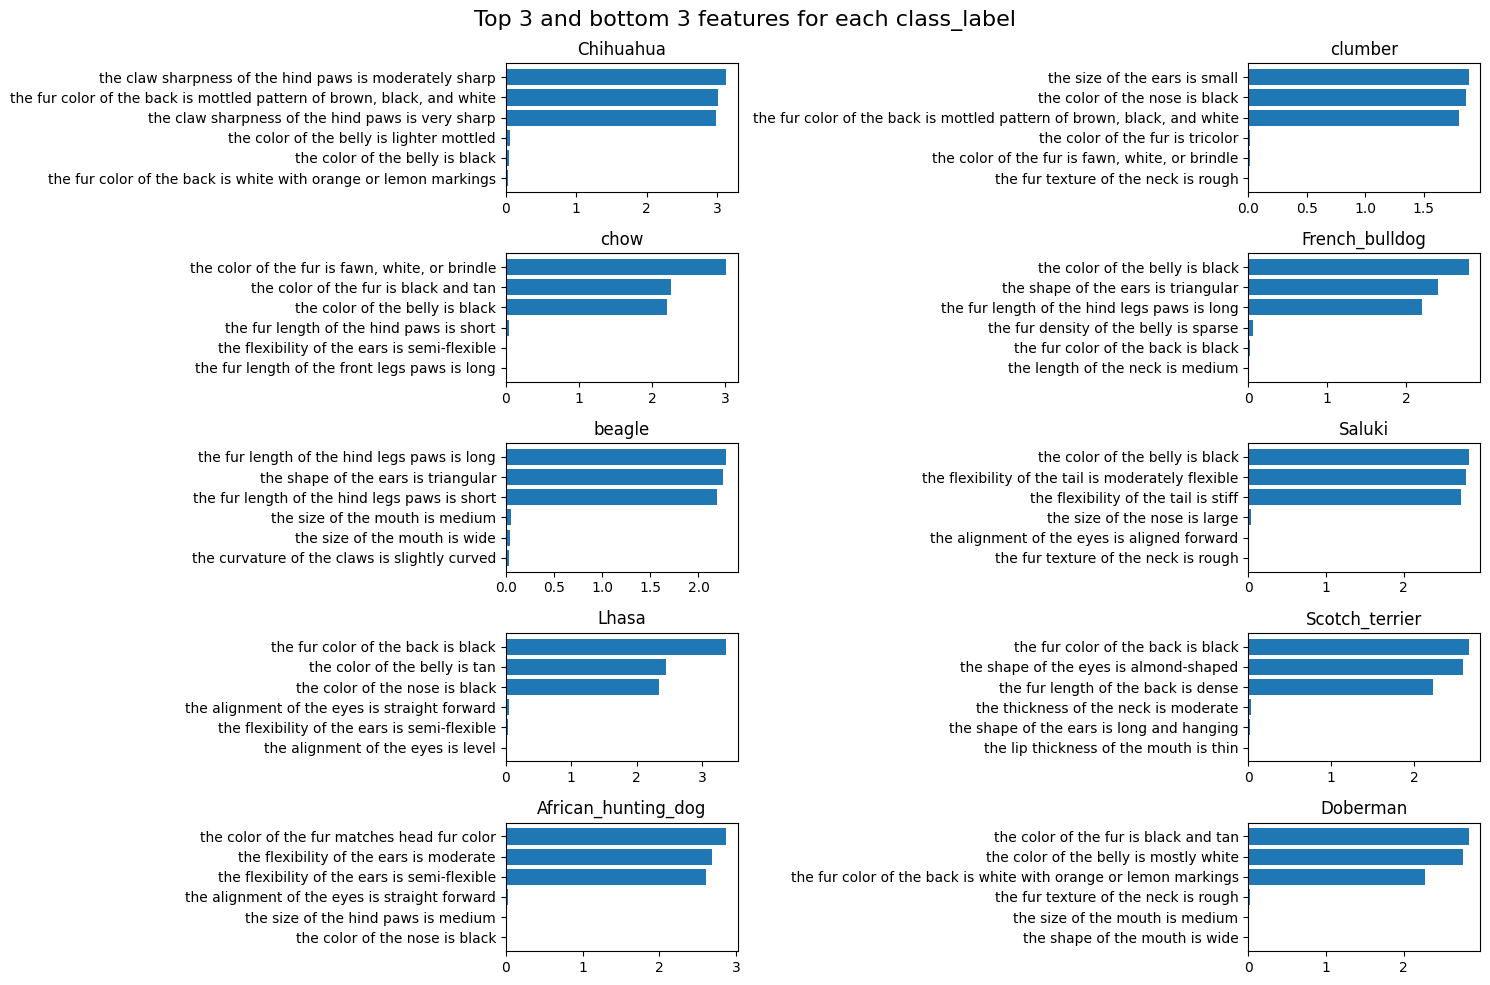

In [167]:
n_classes = len(feature_importances.columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axes_flat = axes.flatten()

for i, class_label in enumerate(feature_importances.columns):
    top_features = feature_importances[class_label].nlargest(3)
    bottom_features = feature_importances[class_label].nsmallest(3)

    combined_features = pd.concat([top_features, bottom_features])
    combined_features = combined_features.reindex(combined_features.abs().sort_values(ascending=True).index)

    ax = axes_flat[i]
    ax.barh(combined_features.index, combined_features)
    ax.set_title(f"{class_label}")
    ax.axvline(x=0, color='grey', linewidth=0.5)  # Line at zero for reference

fig.suptitle('Top 3 and bottom 3 features for each class_label', fontsize=16)
plt.tight_layout()
plt.show()

## Focus on confusing class_labels

In [236]:
class_label1 = 'Scotch_terrier'
class_label2 = 'Lhasa'

top_features_class_label1 = feature_importances[class_label1].nlargest(30).index
top_features_class_label2 = feature_importances[class_label2].nlargest(30).index
common_features = top_features_class_label1.intersection(top_features_class_label2)
common_feature_values = feature_importances.loc[common_features, [class_label1, class_label2]]
common_feature_values

,Scotch_terrier,Lhasa
the fur color of the back is black,2.656080,3.367112
the shape of the eyes is almond-shaped,2.578711,1.919944
the texture of the fur is silky,1.929210,0.974126
the density of the fur is dense,1.888726,1.105117
the size of the hind legs paws is medium,1.583389,1.096661
the fur texture of the neck is silky,1.538228,1.013355
the color of the belly is black,1.458316,2.304305
the fur texture of the neck is rough,1.394154,1.393034
the texture of the fur is rough,1.327747,1.315600
the texture of the fur is straight,1.260109,0.994739


In [99]:
label_mapping

{'African_hunting_dog': 0,
 'Chihuahua': 1,
 'Doberman': 2,
 'French_bulldog': 3,
 'Lhasa': 4,
 'Saluki': 5,
 'Scotch_terrier': 6,
 'beagle': 7,
 'chow': 8,
 'clumber': 9}

In [169]:
X_test_label[(X_test_label.class_label == 'Lhasa')&(X_test_label.pred == 'Scotch_terrier')]

,class_label,image_name,pred
1204,Lhasa,n02098413_1137,Scotch_terrier
1058,Lhasa,n02098413_2199,Scotch_terrier


In [25]:
# to get SHAP values, we need to train a dedicated model where target classes are encoded

df_classification = df_classification.reset_index(drop=True)
X_wo_label = df_classification.drop(columns=['class_label', 'image_name'])
y = df_classification['class_label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# we train the model with most important features
with open('most_important_features.pkl', 'rb') as f:
    most_important_features_list = pickle.load(f)
X_wo_label = X_wo_label[most_important_features_list]

X_train, X_test, y_train, y_test = train_test_split(X_wo_label, y_encoded, test_size=0.1, random_state=42)

#model_shap = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model_shap = RandomForestClassifier(random_state=42, n_jobs=-1)
model_shap.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [175]:
label_mapping

{'African_hunting_dog': 0,
 'Chihuahua': 1,
 'Doberman': 2,
 'French_bulldog': 3,
 'Lhasa': 4,
 'Saluki': 5,
 'Scotch_terrier': 6,
 'beagle': 7,
 'chow': 8,
 'clumber': 9}

In [26]:
index_focus = 1058
true_class = X_test_label.loc[index_focus, 'class_label']
true_class_encoded = label_mapping[true_class]
pred_class = X_test_label.loc[index_focus, 'pred']
pred_class_encoded = label_mapping[pred_class]

In [27]:
model.predict_proba([X_wo_label.loc[index_focus,:]])

/opt/conda/envs/libsearch/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.06, 0.05, 0.06, 0.  , 0.18, 0.1 , 0.2 , 0.06, 0.13, 0.16]])

In [28]:
model_shap.predict_proba([X_wo_label.loc[index_focus,:]])

/opt/conda/envs/libsearch/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.06, 0.05, 0.06, 0.  , 0.18, 0.1 , 0.2 , 0.06, 0.13, 0.16]])

In [29]:
explainer = shap.TreeExplainer(model_shap)
shap_values = np.array(explainer.shap_values(X_wo_label))
print(shap_values.shape)

(1715, 114, 10)


In [30]:
sample_shap_values_true = shap_values[index_focus, :, true_class_encoded]
sample_shap_values_pred = shap_values[index_focus, :, pred_class_encoded]

base_value_true = explainer.expected_value[true_class_encoded]
base_value_pred = explainer.expected_value[pred_class_encoded]

sample_features = X_wo_label.loc[index_focus,:]
feature_names = X_wo_label.columns if hasattr(X_wo_label, 'columns') else None

def map_to_visual_clue(value):
    for key, values in collected_values.items():
        if value in values:
            return key
    return None

feature_names = list(feature_names)
feature_names_reduced = [map_to_visual_clue(feature)+':'+feature.split('is')[1] if 'is' in feature else feature for feature in feature_names]

shap.force_plot(
    base_value_pred,
    sample_shap_values_pred,
    sample_features,
    feature_names=feature_names_reduced
)

SHAP values for the true label : Lhasa


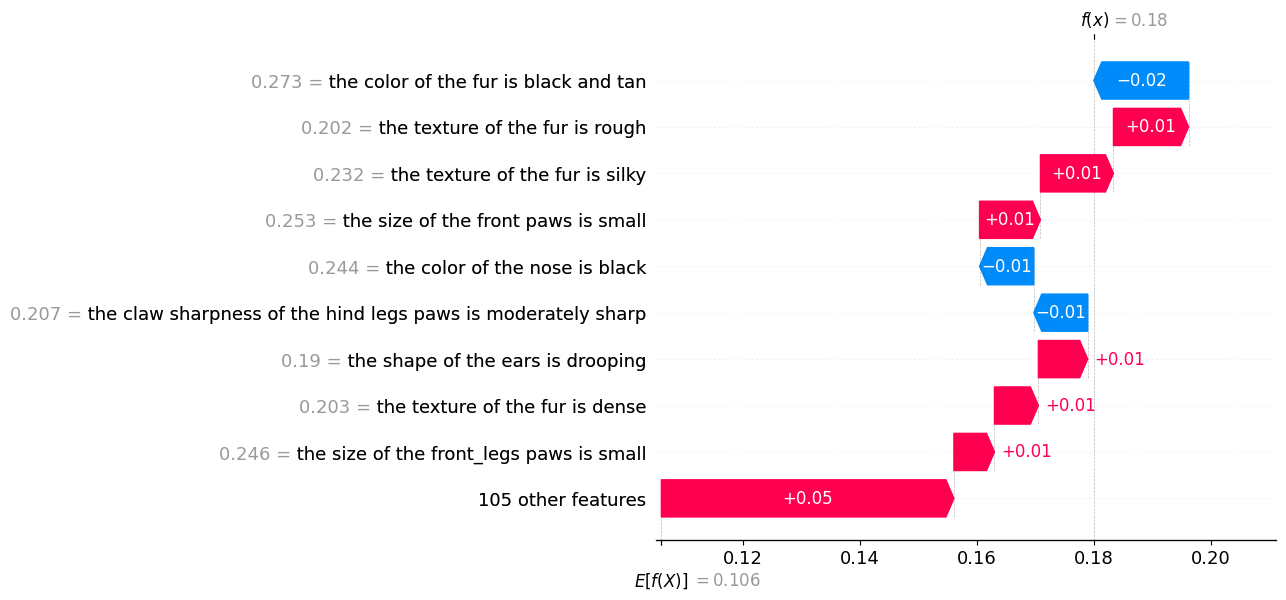

In [31]:
print(f"SHAP values for the true label : {true_class}")

shap.plots.waterfall(
    shap.Explanation(
        values=sample_shap_values_true,
        base_values=base_value_true,
        feature_names=feature_names,
        data=sample_features
    ),
    max_display=10
)

SHAP values for the pred label : Scotch_terrier


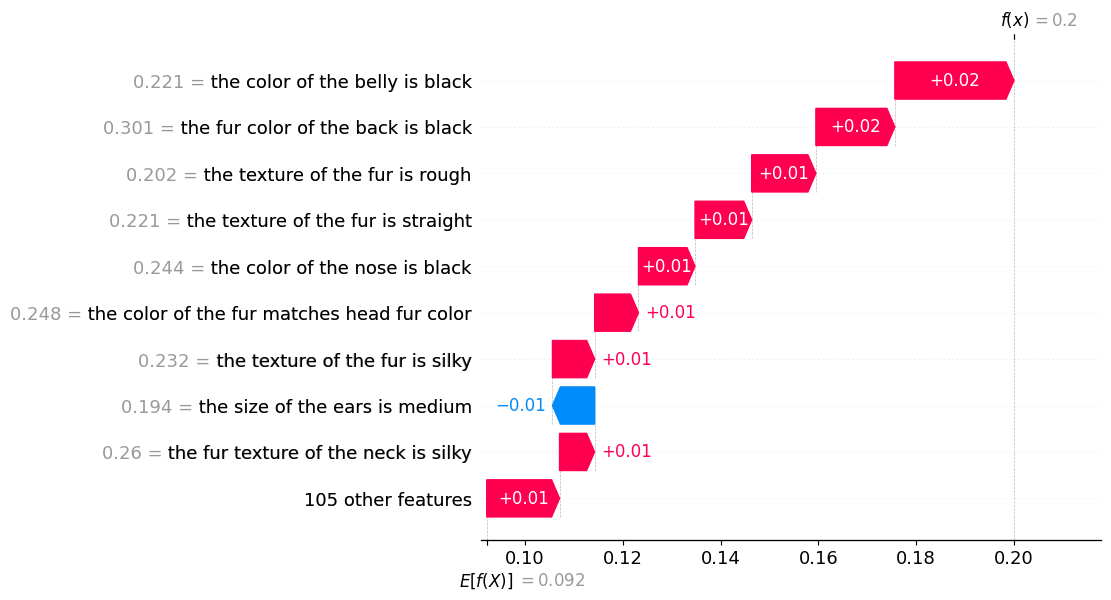

In [32]:
print(f"SHAP values for the pred label : {pred_class}")

shap.plots.waterfall(
    shap.Explanation(
        values=sample_shap_values_pred,
        base_values=base_value_pred,
        feature_names=feature_names,
        data=sample_features
    ),
    max_display=10
)

## Specific image prediction

In [41]:
def image_prediction_output(image_name, image_dir, label_dir, annotation_dir, text_embeddings, model):
    
    image_path = os.path.join(image_dir, label_dir, image_name+'.jpg')
    annotation_path = os.path.join(annotation_dir, label_dir, image_name)
    
    bounding_boxes = parse_annotation(annotation_path)
    image = Image.open(image_path)
    cropped_image = image.crop(bounding_boxes[0])

    image_text_similarities = get_image_cosine_similarities(image_name=image_name,
                                                            image_dir=image_dir,
                                                            label_dir=label_dir,
                                                            annotation_dir=annotation_dir,
                                                            text_embeddings=text_embeddings)
    
    df_pred = pd.DataFrame.from_dict(image_text_similarities, orient='index').T
    df_pred = df_pred[X_test.columns]
    
    print(f"\nthe true class_label is : {label_dir.split('-')[1]}")
    print(f"the predicted class_label is : {model.predict(df_pred)[0]}")
    
    probas = list(model.predict_proba(df_pred)[0])
    class_labels = list(model.classes_)
    prediction_probas = dict(zip(class_labels, probas))
    sorted_prediction_probas = dict(sorted(prediction_probas.items(), key=lambda item: item[1], reverse=False))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) #gridspec_kw={'width_ratios': [1.5, 1]}
                                   
    ax1.imshow(cropped_image)
    ax1.axis('off')
    
    ax2.barh(sorted_prediction_probas.keys(), sorted_prediction_probas.values())
    ax2.set_title('Model output probabilities for each class_label')


the true class_label is : Lhasa
the predicted class_label is : Scotch_terrier


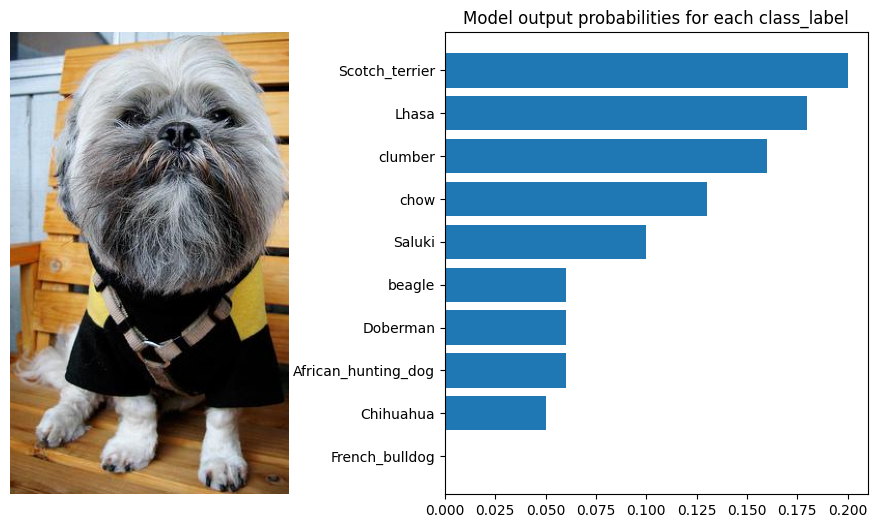

In [42]:
image_dir='../libsearch/stanford-dogs/images/Images'
annotation_dir = '../libsearch/stanford-dogs/annotations/Annotation'
label_dir = 'n02098413-Lhasa'
image_name = 'n02098413_2199'


image_prediction_output(image_name, image_dir, label_dir, annotation_dir, visual_clues_embeddings, model)


the true class_label is : French_bulldog
the predicted class_label is : French_bulldog


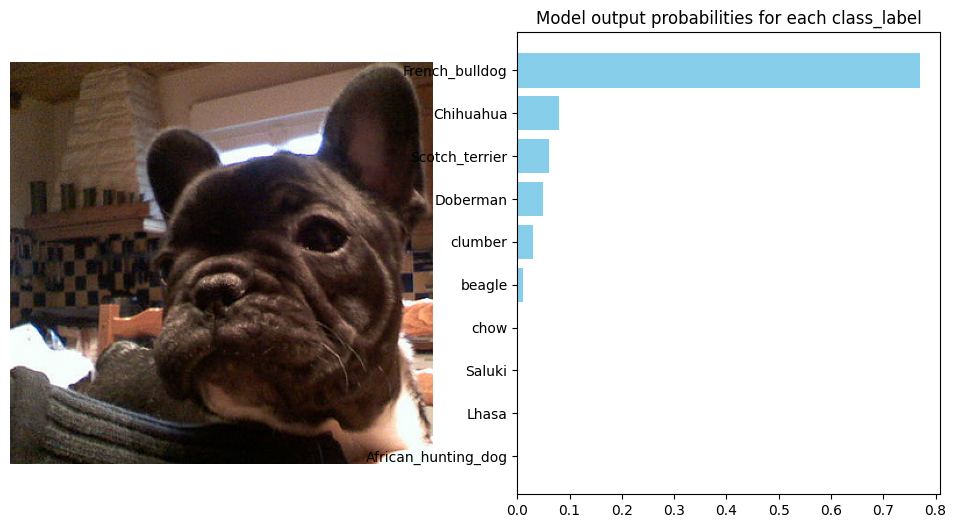

In [40]:
image_dir='../libsearch/stanford-dogs/images/Images'
annotation_dir = '../libsearch/stanford-dogs/annotations/Annotation'
label_dir = 'n02108915-French_bulldog'
image_name = 'n02108915_8923'

image_prediction_output(image_name, image_dir, label_dir, annotation_dir, visual_clues_embeddings, model)

SHAP values for the pred label : French_bulldog


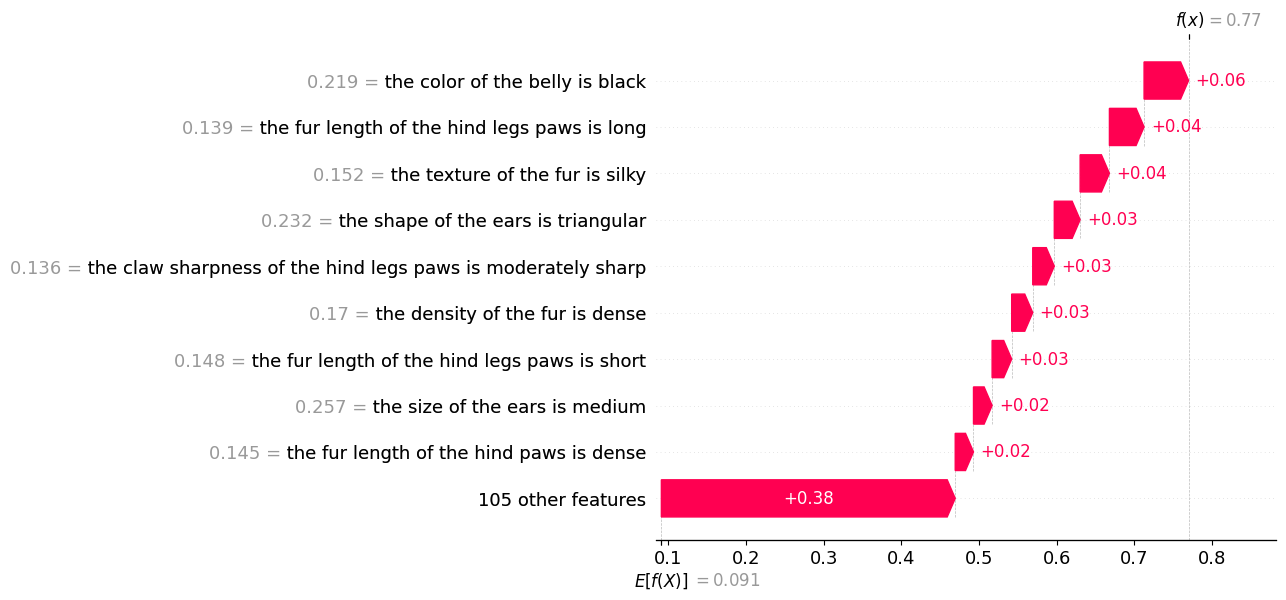

In [41]:
index_focus = 610
true_class = X_test_label.loc[index_focus, 'class_label']
true_class_encoded = label_mapping[true_class]
pred_class = X_test_label.loc[index_focus, 'pred']
pred_class_encoded = label_mapping[pred_class]

sample_shap_values_true = shap_values[index_focus, :, true_class_encoded]
sample_shap_values_pred = shap_values[index_focus, :, pred_class_encoded]

base_value_true = explainer.expected_value[true_class_encoded]
base_value_pred = explainer.expected_value[pred_class_encoded]

sample_features = X_wo_label.loc[index_focus,:]
feature_names = X_wo_label.columns if hasattr(X_wo_label, 'columns') else None

feature_names = list(feature_names)
feature_names_reduced = [map_to_visual_clue(feature)+':'+feature.split('is')[1] if 'is' in feature else feature for feature in feature_names]

print(f"SHAP values for the pred label : {pred_class}")

shap.plots.waterfall(
    shap.Explanation(
        values=sample_shap_values_pred,
        base_values=base_value_pred,
        feature_names=feature_names,
        data=sample_features
    ),
    max_display=10
)

# Compare with CNN model

In [188]:
# Define paths
base_dir = "../stanford-dogs"
images_dir = os.path.join(base_dir, "images", "Images")
annotations_dir = os.path.join(base_dir, "annotations", "Annotation")

# Prepare the dataset by parsing annotations and cropping images
def parse_annotations():
    data = []
    for breed_folder in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, breed_folder)
        image_path = os.path.join(images_dir, breed_folder)

        if not os.path.isdir(annotation_path):
            continue

        for annotation_file in os.listdir(annotation_path):
            annotation_file_path = os.path.join(annotation_path, annotation_file)
            image_file = f"{annotation_file}.jpg"
            image_file_path = os.path.join(image_path, image_file)

            if not os.path.exists(image_file_path):
                continue

            # Parse XML to get bounding box
            tree = ET.parse(annotation_file_path)
            root = tree.getroot()
            bndbox = root.find(".//bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Save record
            label = breed_folder
            data.append({
                "image_path": image_file_path,
                "bbox": (xmin, ymin, xmax, ymax),
                "label": label
            })
    return data

# Custom dataset class to handle cropping and transforms
class StanfordDogsDataset(Dataset):
    def __init__(self, data, transform=None, label_map=None):
        self.data = data
        self.transform = transform
        self.label_map = label_map or {label: idx for idx, label in enumerate(sorted({d['label'] for d in data}))}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data[idx]
        image = Image.open(record["image_path"]).convert("RGB")
        xmin, ymin, xmax, ymax = record["bbox"]
        image = image.crop((xmin, ymin, xmax, ymax))  # Crop the image
        label = self.label_map[record["label"]]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Parse dataset
data = parse_annotations()

# Create train/test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=[d["label"] for d in data])

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize datasets and dataloaders
label_map = {label: idx for idx, label in enumerate(sorted({d['label'] for d in data}))}
train_dataset = StanfordDogsDataset(train_data, transform=transform, label_map=label_map)
test_dataset = StanfordDogsDataset(test_data, transform=transform, label_map=label_map)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [189]:
label_map

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [ ]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Reduce filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Smaller fully connected layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Epoch 1/5, Loss: 4.4189, Accuracy: 3.60%
Epoch 2/5, Loss: 3.9144, Accuracy: 9.69%
Epoch 3/5, Loss: 3.3292, Accuracy: 19.44%


In [ ]:
# comparer les accuracies
# comparer les matrices de confusion

In [195]:
100 * correct / total

10.276967930029155